# Laboratory Work 1 (var 2)

Multiclass Classification with PyTorch

In [ ]:
# @title Imports {display-mode: "form"}

import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.optim as optim
from IPython import display
from google.colab import files
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from torch import nn
from torch.utils.data import Dataset
from tqdm import tqdm

In [ ]:
# @title Env Preparation {display-mode: "form"}
pd.options.mode.chained_assignment = None

# Load Dataset

In [ ]:
files.upload()

Saving var2.csv to var2.csv


In [ ]:
df = pd.read_csv('var2.csv', header=0, names=['label', 'text'])
df

,label,text
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
50419,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50420,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50421,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50422,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


Датасет представляет собой описание, вероятно, некоторых товаров. Лейблами являются типы товаров.

# EDA

## Overlook

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50424 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


Среди текстов присутствует один null, имеет смысл удалить строку с ним.

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50423 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50423 non-null  object
 1   text    50423 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df.describe()

,label,text
count,50423,50423
unique,4,27801
top,Household,Think & Grow Rich About the Author NAPOLEON HI...
freq,19312,30


Наблюдения:
* Тексты в датасете поделены на 4 класса
* Самый частотный класс -- Household, встречающийся 19312 раз
* В датасете большое количество повторяющихся текстов (из 50423 только 27801 уникальный)
  * Так, мы можем видеть текст, встречающийся в датасете 30 раз

In [ ]:
df.loc[df['text'] == """Think & Grow Rich About the Author NAPOLEON HILL, born in Pound, Southwest Virginia in 1883, was a very successful American author in the area of the new thought movement—one of the earliest producers of the modern genre of personal-success literature. He is widely considered to be one of the great writers on success. The turning point in Hill’s life occurred in the year 1908 when he interviewed the industrialist Andrew Carnegie—one of the most powerful men in the world at that time, as part of an assignment—an interview which ultimately led to the publication of Think and Grow Rich, one of his best-selling books of all time. the book examines the power of personal beliefs and the role they play in personal success. Hill, who had even served as the advisor to President Franklin D. Roosevelt from 1933-36, passed away at the age of 87."""]

,label,text
19465,Books,Think & Grow Rich About the Author NAPOLEON HI...
19765,Books,Think & Grow Rich About the Author NAPOLEON HI...
20157,Books,Think & Grow Rich About the Author NAPOLEON HI...
20833,Books,Think & Grow Rich About the Author NAPOLEON HI...
21185,Books,Think & Grow Rich About the Author NAPOLEON HI...
24478,Books,Think & Grow Rich About the Author NAPOLEON HI...
24480,Books,Think & Grow Rich About the Author NAPOLEON HI...
24498,Books,Think & Grow Rich About the Author NAPOLEON HI...
26046,Books,Think & Grow Rich About the Author NAPOLEON HI...
26163,Books,Think & Grow Rich About the Author NAPOLEON HI...


In [ ]:
df.sample(15, random_state=6)

,label,text
6716,Household,DM COOL COTTON - Oven Gloves - Pack of 2 (Asso...
4288,Household,JaipurCrafts Designer Econo Gelato Small Hooka...
45054,Electronics,JBL GO Portable Wireless Bluetooth Speaker wit...
30297,Books,Difficult Women
36415,Clothing & Accessories,Perfectblue Women's Linen Saree With Blouse Pi...
30549,Books,Homo Deus: A Brief History of Tomorrow Review ...
45383,Electronics,Boya by M1 Lavalier Microphone for Smartphones...
36905,Clothing & Accessories,Xs and Os Women Halter Neck Babydoll Lingerie ...
35353,Clothing & Accessories,VIMAL Premium Suit Fabric for Men (3 Meter Sui...
14644,Household,Whirlpool 14 Place Settings Dishwasher (PowerC...


Наблюдения:
* Большинство текстов в датасете достаточно объёмные
* Тем не менее, встречаются и небольшие тексты
* Во многих текстах содержатся числовые обозначения, небуквенные символы и сокращения

## Labels Distribution

In [ ]:
labels_quant = df['label'].value_counts()
labels_percent = [f'{round(_, 2) * 100}%' for _ in df['label'].value_counts(normalize=True)]
pd.DataFrame({'quantity': labels_quant, 'percentage': labels_percent})

,quantity,percentage
Household,19312,38.0%
Books,11820,23.0%
Electronics,10621,21.0%
Clothing & Accessories,8670,17.0%


Дисбаланс классов в датасете присутствует, но не очень сильный. Количество элементов в наибольшем классе немногим более чем в два раза больше, чем количество элементов в наименьшем классе.

## Text Lengths

array([[<Axes: title={'center': 'tokenized_text_len'}>]], dtype=object)

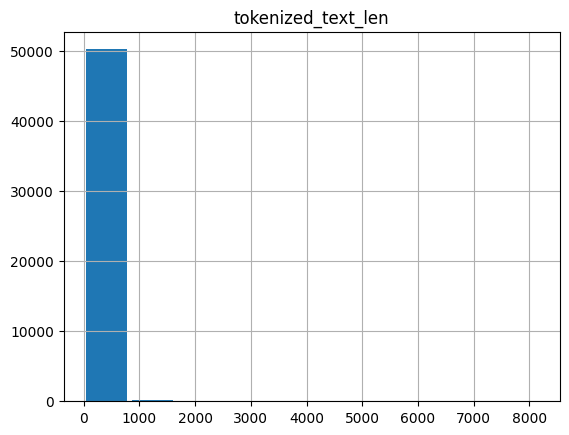

In [ ]:
df['tokenized_text_len'] = [len(text.split()) for text in df['text']]
df.hist(column='tokenized_text_len', rwidth=0.9)

In [ ]:
round(sum(len(text.split()) for text in df['text']) / len(df['text']), 2)

114.18

Подавляющее большинство текстов в датасете содержит от нуля до тысячи токенов, присутствует небольшое количество текстов длиной до двух тысяч токенов, однако, судя по значениям на оси x графика, есть и аномально длинные тексты.

In [ ]:
longest_text = max(df['text'], key=len)
print(f'''Longest text: "{longest_text}"

Words count: {len(longest_text.split())}''')

Longest text: "Risk Savvy: How to Make Good Decisions About the Author Gerd Gigerenzer is the author of Gut Feelings. He is currently the director of the Max Planck Institute for Human Development in Berlin, Germany, and lectures around the world on the importance of proper risk education for everyone from school-age children to prominent doctors, bankers, and politicians. 				    	 					 Excerpt. © Reprinted by permission. All rights reserved. Praise for Gerd Gigerenzer’s Work“Logic be damned! . . . Gigerenzer delivers a convincing argument for going with your gut.”—Men’s Health“All innumerates—buyers, sellers, students, professors, doctors, patients, lawyers and their clients, politicians, voters, writers, and readers—have something to learn from Gigerenzer.” —Publishers Weekly“Gladwell drew heavily on Gigerenzer’s research. But Gigerenzer goes a step further by explaining just why our gut instincts are so often right.” —Businessweek“[Gigerenzer] has the gift of exposition and severa

Изучив данный текст, я пришёл к выводу, что это описание книги, возможно, вместе с частью её содержимого или некоторым ознакомительным фрагментом. Судя по графику, более 50_000 текстов содержат до 2_000 токенов, поэтому, я считаю, можно удалить из датасета очень длинные тексты.

In [ ]:
df = df.loc[df['tokenized_text_len'] < 2000]
df

,label,text,tokenized_text_len
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",59
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,224
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",184
3,Household,Incredible Gifts India Wooden Happy Birthday U...,184
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,230
...,...,...,...
50419,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,88
50420,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,16
50421,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,288
50422,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou...",322


In [ ]:
shortest_text = min(df['text'], key=len)
print(f'''Shortest text: "{shortest_text}"

Words count: {len(shortest_text.split())}''')

Shortest text: "Yes!"

Words count: 1


In [ ]:
df.loc[df['text'] == 'Yes!']

,label,text,tokenized_text_len
25313,Books,Yes!,1


Данный текст неинформативен. Таким образом, имеет смысл избавиться и от слишком коротких текстов.

In [ ]:
df.loc[df['tokenized_text_len'] < 5].shape

(986, 3)

Поскольку датасет содержит описания некоторых предметов, я решил удалить тексты длиной до 5-и токенов, таким образом, удалив ещё около тысячи строк.

In [ ]:
df = df.loc[df['tokenized_text_len'] > 5]
df

,label,text,tokenized_text_len
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",59
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,224
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",184
3,Household,Incredible Gifts India Wooden Happy Birthday U...,184
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,230
...,...,...,...
50418,Electronics,"Nokia Lumia 530 (Dual SIM, Grey) Colour:Grey ...",411
50419,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...,88
50420,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...,16
50421,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...,288


Снова проверим распределение длин текстов.

array([[<Axes: title={'center': 'tokenized_text_len'}>]], dtype=object)

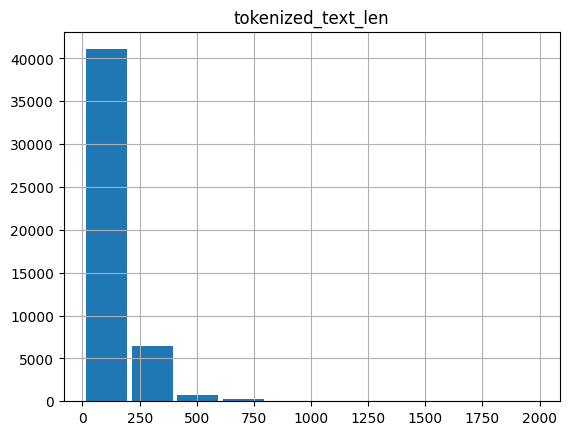

In [ ]:
df.hist(column='tokenized_text_len', rwidth=0.9)

In [ ]:
round(sum(len(text.split()) for text in df['text']) / len(df['text']), 2)

115.83

In [ ]:
# Clear abundant column
df.drop('tokenized_text_len', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,label,text
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
48743,Electronics,"Nokia Lumia 530 (Dual SIM, Grey) Colour:Grey ..."
48744,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
48745,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
48746,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...


Проверим, как изменился баланс классов в датасете.

In [ ]:
labels_quant = df['label'].value_counts()
labels_percent = [f'{round(_, 2) * 100}%' for _ in df['label'].value_counts(normalize=True)]
pd.DataFrame({'quantity': labels_quant, 'percentage': labels_percent})

,quantity,percentage
Household,19224,39.0%
Electronics,10585,22.0%
Books,10561,22.0%
Clothing & Accessories,8378,17.0%


Баланс классов изменился не сильно, хоть и сместился в сторону класса Household.

# Preprocessing

## Encode Labels

In [ ]:
df['label'] = pd.factorize(df['label'])[0]
df

,label,text
0,0,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,0,SAF 'UV Textured Modern Art Print Framed' Pain...
2,0,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,0,Incredible Gifts India Wooden Happy Birthday U...
4,0,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
48743,3,"Nokia Lumia 530 (Dual SIM, Grey) Colour:Grey ..."
48744,3,Strontium MicroSD Class 10 8GB Memory Card (Bl...
48745,3,CrossBeats Wave Waterproof Bluetooth Wireless ...
48746,3,Karbonn Titanium Wind W4 (White) Karbonn Titan...


## Preprocess Texts

Имеет смысл на этом этапе удалить дублирующиеся строки из датасета, чтобы предобработка занимала меньше времени.

In [ ]:
df.drop_duplicates('text', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(26919, 2)

In [ ]:
df['label'].value_counts()

0    10511
1     5583
2     5536
3     5289
Name: label, dtype: int64

Удалилась почти половина датасета, при этом классы стали более сбалансированы.

Поскольку средняя длина текстов составляет 115 токенов, можно попробовать оставить только значимые части речи. Поскольку обработка текстов при помощи SpaCy проходила слишком медленно, я решил использовать для этого библиотеку NLTK.

In [ ]:
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
def preprocess_text(text):
  tokens = word_tokenize(text)
  tagged = nltk.pos_tag(tokens)
  filtered_text = [lemmatizer.lemmatize(word.lower()) for word, pos_tag in tagged
                   if not word.lower() in stop_words and pos_tag in ['JJ', 'JJR', 'JJS', 'NN', 'NNP', 'NNPS', 'NNS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']] # Leave only adjectives, nouns, verbs and adverbs that are not in stop-words list
  preprocessed_text = clear_text(' '.join(filtered_text))
  return preprocessed_text

def clear_text(text):
  return ' '.join(re.findall(r'[a-z]{2,}', text.lower()))

In [ ]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(preprocess_text)
df

100%|██████████| 26919/26919 [03:43<00:00, 120.25it/s]


,label,text
0,0,saf floral framed painting wood inch inch spec...
1,0,saf textured modern art print framed painting ...
2,0,saf flower print framed painting synthetic inc...
3,0,incredible gift india wooden happy birthday un...
4,0,pitaara box romantic venice canvas painting th...
...,...,...
26914,3,micromax bharat zero impact visual display scr...
26915,3,microsoft lumia black microsoft lumia experien...
26916,3,microsoft lumia black colour black product des...
26917,3,karbonn titanium wind white karbonn titanium w...


Удалим дублирующиеся строки ещё раз на случай, если такие появились после предобработки текста.

In [ ]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(26547, 2)

In [ ]:
df['label'].value_counts()

0    10388
1     5509
2     5437
3     5213
Name: label, dtype: int64

# Vectorizing

В нашем случае для классификации должно хватить one hot векторов, создадим их.

In [ ]:
from collections import Counter
all_words = []

df['text'].apply(lambda x : all_words.extend(x.split()))

word_counter = Counter(all_words)
word_counter.most_common(300)

[('book', 8631),
 ('product', 8387),
 ('size', 7978),
 ('set', 7081),
 ('quality', 6597),
 ('use', 6571),
 ('color', 6449),
 ('time', 6352),
 ('design', 6318),
 ('make', 6313),
 ('easy', 6223),
 ('made', 6156),
 ('high', 6031),
 ('home', 5789),
 ('black', 5702),
 ('also', 5573),
 ('author', 5424),
 ('cotton', 4869),
 ('new', 4827),
 ('material', 4762),
 ('feature', 4638),
 ('inch', 4583),
 ('light', 4534),
 ('come', 4431),
 ('woman', 4388),
 ('power', 4323),
 ('look', 4198),
 ('perfect', 4189),
 ('best', 4046),
 ('life', 4027),
 ('year', 3931),
 ('used', 3665),
 ('steel', 3587),
 ('usb', 3570),
 ('fit', 3530),
 ('water', 3514),
 ('long', 3507),
 ('work', 3478),
 ('cm', 3414),
 ('style', 3405),
 ('designed', 3357),
 ('free', 3279),
 ('white', 3235),
 ('camera', 3127),
 ('men', 3092),
 ('top', 3073),
 ('fabric', 3073),
 ('give', 3066),
 ('table', 3054),
 ('device', 3021),
 ('colour', 3009),
 ('keep', 2991),
 ('need', 2960),
 ('world', 2940),
 ('soft', 2927),
 ('help', 2916),
 ('well', 27

Построим вектора на 300-х самых частотных слов со встречаемостью > 1000.

In [ ]:
bow = [i[0] for i in word_counter.most_common(300)]
bow.append('UNK')
ohe_list = []

for i, row in tqdm(df.iterrows()):
    text = row['text'].split()
    ohe_vector = [0 for i in bow]
    for word in text:
        if word in bow:
            word_index = bow.index(word)
            ohe_vector[word_index] = 1
        else:
            ohe_vector[-1] = 1
    ohe_list.append(ohe_vector)

ohe_df = pd.DataFrame(ohe_list, columns=bow)
ohe_df['label'] = df['label']
ohe_df

26547it [00:12, 2109.01it/s]


,book,product,size,set,quality,use,color,time,design,make,...,wooden,extra,height,watt,powerful,research,medium,head,UNK,label
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
26543,0,0,0,1,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,1,3
26544,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,3
26545,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,3


In [ ]:
labels = np.array(ohe_df['label'])
data = np.array(ohe_df.drop('label', axis=1))
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.2, random_state=6)
data_train.shape, data_test.shape

((21237, 301), (5310, 301))

Разделим тренировочную выборку для кросс-валидации.

In [ ]:
train_vars = []
valid_vars = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=6)
split_vars= sss.split(data_train, label_train)

for train_index, val_index in split_vars:
  train_vars.append(train_index)
  valid_vars.append(val_index)

# Visualization

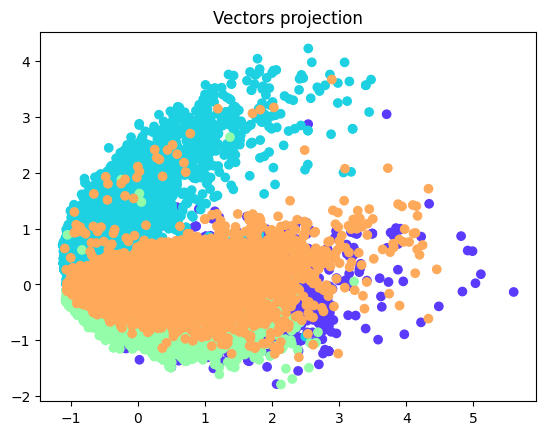

In [ ]:
pca = PCA(n_components=2)
d2 = pca.fit_transform(data)
color_palette = sns.color_palette('rainbow', 12)

plt.scatter(
    d2[:, 0],
    d2[:, 1],
    c= [color_palette[int(x) * 3] for x in labels])
plt.title('Vectors projection', fontsize=12)
plt.show()

На графике хорошо отделяется только один класс, в то время как три остальные накладываются друг на друга.

# Model Compilation

## Build model

In [ ]:
device = torch.device('cpu')

In [ ]:
def build_model(data):
  model = nn.Sequential(
      nn.Linear(data.shape[1], 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 4)
      ).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  return model, criterion, optimizer

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, input_df, target_df, transform=None):
    self.input_df = input_df
    self.target_df = target_df
    self.transform = transform

  def __len__(self):
    return len(self.input_df)

  def __getitem__(self, index):
    # Get the input and target data at the specified index
    input_tensor = torch.tensor(self.input_df[index], dtype=torch.float32)
    target_tensor = torch.tensor(self.target_df[index], dtype=torch.float32)
    return input_tensor, target_tensor

## Cross Validation

In [ ]:
loss_history = pd.DataFrame()

for ind, (train_id, val_id) in enumerate(zip(train_vars, valid_vars)):
  print(f'training model № {ind}')
  train_loader = torch.utils.data.DataLoader(CustomDataset(np.array([data_train[i] for i in train_id]), np.array([label_train[i] for i in train_id])), 1024, shuffle=True)
  val_loader = torch.utils.data.DataLoader(CustomDataset(np.array([data_train[i] for i in val_id]), np.array([label_train[i] for i in val_id])), 1024, shuffle=True)

  model, criterion, optimizer = build_model(data_train) # creating new model each iteration
  train_loss_history = []
  val_loss_history = []

  for epoch in range(15):
    # Training
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass and compute the loss
      outputs = model(inputs.view(inputs.size(0), -1))
      loss = criterion(outputs, labels.type(torch.LongTensor))

      # Backward pass and optimize the parameters
      loss.backward()
      optimizer.step()

      # Compute statistics
      running_loss += loss.item()
      if i == len(train_loader) - 1:
        train_loss = running_loss / 100
        train_loss_history.append(train_loss)

    # Validation
    with torch.no_grad():
      running_loss = 0.0
      for i, (inputs, labels) in enumerate(val_loader):
        # Forward pass and compute the loss
        outputs = model(inputs.view(inputs.size(0), -1))
        loss = criterion(outputs, labels.type(torch.LongTensor))

        # Compute statistics
        running_loss += loss.item()
        if i == len(val_loader) - 1:
          val_loss = running_loss / 100
          val_loss_history.append(val_loss)

    print(f'epoch {epoch + 1}\ttrain loss {train_loss}\tval loss {val_loss}')

  loss_history[f'train M{ind}'] = train_loss_history
  loss_history[f'val M{ind}'] = val_loss_history

  display.clear_output(wait=True)

training model № 4
epoch 1	train loss 0.1329897537827492	val loss 0.020250109136104585
epoch 2	train loss 0.06453266501426697	val loss 0.01822446972131729
epoch 3	train loss 0.05322786524891853	val loss 0.01844255208969116
epoch 4	train loss 0.047611934393644334	val loss 0.01688048630952835
epoch 5	train loss 0.04407734617590904	val loss 0.015751580744981765
epoch 6	train loss 0.039755918085575104	val loss 0.018325406312942504
epoch 7	train loss 0.03551400825381279	val loss 0.01759093552827835
epoch 8	train loss 0.030563917756080628	val loss 0.01783209800720215
epoch 9	train loss 0.025399996191263197	val loss 0.018318147361278535
epoch 10	train loss 0.021507861912250518	val loss 0.021123775839805604
epoch 11	train loss 0.017905410677194596	val loss 0.023908245861530304
epoch 12	train loss 0.015650373250246048	val loss 0.024446553289890288
epoch 13	train loss 0.013173723667860031	val loss 0.02540074586868286
epoch 14	train loss 0.011496310159564017	val loss 0.030857033729553222
epoch 15

<Axes: title={'center': 'Cross Validation Loss'}, xlabel='epochs'>

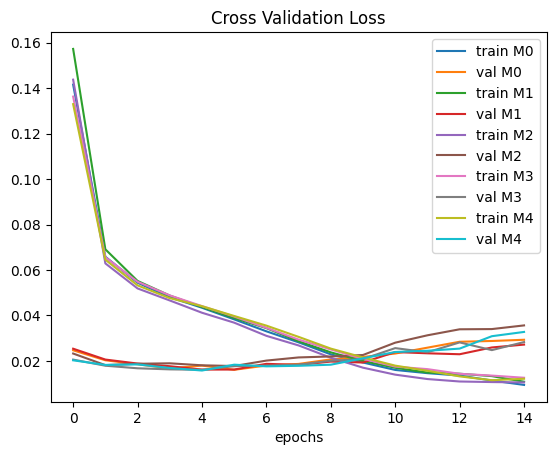

In [ ]:
loss_history.plot(title='Cross Validation Loss', xlabel='epochs')

Не уверен, с чем это может быть связано, но увеличение размера батчей позволило увеличить количество эпох, необходимых до начала переобучения модели.

Из графика видно, что модель обучается стабильно, обучение можно остановить на 10-й эпохе, хотя я затрудняюсь сказать, не переобучилась ли модель к этому моменту: значение функции потерь на валидационной выборке изначально очень низкое и достаточно быстро начинает стабильно расти, однако именно здесь оно становится немного выше, чем на тренировочной выборке.

# Classification

## Model Training

In [ ]:
train_loader = torch.utils.data.DataLoader(CustomDataset(data_train, label_train), 1024, shuffle=True)
model, criterion, optimizer = build_model(data_train)

for epoch in range(10):
    # Training
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass and compute the loss
      outputs = model(inputs.view(inputs.size(0), -1))
      loss = criterion(outputs, labels.type(torch.LongTensor))

      # Backward pass and optimize the parameters
      loss.backward()
      optimizer.step()

      # Compute statistics
      running_loss += loss.item()
      if i == len(train_loader) - 1:
        train_loss = running_loss / 100
        print(f'epoch {epoch + 1} train loss {train_loss}')

epoch 1 train loss 0.1447554659843445
epoch 2 train loss 0.07331356048583984
epoch 3 train loss 0.06382519155740737
epoch 4 train loss 0.056418462097644805
epoch 5 train loss 0.051260712146759035
epoch 6 train loss 0.04363738104701042
epoch 7 train loss 0.03677439600229263
epoch 8 train loss 0.03181346207857132
epoch 9 train loss 0.02546495720744133
epoch 10 train loss 0.021008709594607353


## Prediction

In [ ]:
test_loader = torch.utils.data.DataLoader(CustomDataset(data_test, label_test), 1, shuffle=False)
preds = []
with torch.no_grad():
  for inputs, targets in test_loader:
    output = model(inputs)
    prediction = output.tolist()[0]
    preds.append(prediction.index(max(prediction)))
len(preds)

5310

In [ ]:
len(label_test)

5310

In [ ]:
print(classification_report(label_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2041
           1       0.93      0.90      0.91      1146
           2       0.93      0.94      0.93      1080
           3       0.86      0.85      0.85      1043

    accuracy                           0.90      5310
   macro avg       0.90      0.90      0.90      5310
weighted avg       0.90      0.90      0.90      5310



Несмотря на наличие у меня сомнений в процессе обучения, модель демонстрирует высокую точность классификации в 90%.